# Mini Experiment: Signaling

This notebook contains some code for experimenting with the signaling between two NCAs, in a simplified setting.

## Setup

In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import json
import math
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow.keras.layers import Conv2D

from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

from IPython.display import Image, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

clear_output()

In [2]:
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def generate_tiled_figures(figures, fade_by=0.1):
  tiled_pool = tile2d(figures)
  fade_sz = int(tiled_pool.shape[0] * fade_by)
  fade = np.linspace(1.0, 0.0, fade_sz)
  ones = np.ones(fade_sz) 
  tiled_pool[:, :fade_sz] += (-tiled_pool[:, :fade_sz] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -fade_sz:] += (-tiled_pool[:, -fade_sz:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:fade_sz, :] += (-tiled_pool[:fade_sz, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-fade_sz:, :] += (-tiled_pool[-fade_sz:, :] + ones[:, None, None]) * fade[::-1, None, None]
  return tiled_pool

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

## Data loading and manipulation

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.array(x_train / 255.0,).astype(np.float32)
x_test = np.array(x_test / 255.0,).astype(np.float32)

In [4]:
mask_train = (y_train == 0) | (y_train == 1)
mask_test = (y_test == 0) | (y_test == 1)

x_train = x_train[mask_train]
y_train = y_train[mask_train]
x_test = x_test[mask_test]
y_test = y_test[mask_test]

2023-08-31 14:30:40.684451: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-31 14:30:40.684479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-31 14:30:40.684487: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-31 14:30:40.684570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-31 14:30:40.684964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


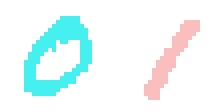

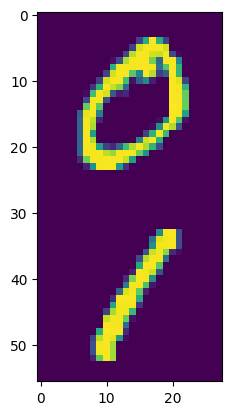

In [5]:
color_lookup = tf.constant([
            [70, 240, 240],
            [250, 190, 190],
            
            [0, 0, 0], # default for digits.
            [255, 255, 255] # This is the background.
            ])
backgroundWhite = True

def color_labels(x, y_pic, disable_black=False, dtype=tf.uint8):
  # works for shapes of x [b, r, c] and [r, c]
  black_and_white = tf.fill(list(x.shape) + [2], 0.01)
  is_gray = tf.cast(x > 0.1, tf.float32)
  is_not_gray = 1. - is_gray

  y_pic = y_pic * tf.expand_dims(is_gray, -1) # forcibly cancels everything outside of it.
  
  # if disable_black, make is_gray super low.
  if disable_black:
    is_gray *= -1e5
    # this ensures that you don't draw white in the digits.
    is_not_gray += is_gray

  bnw_order = [is_gray, is_not_gray] if backgroundWhite else [is_not_gray, is_gray]
  black_and_white *= tf.stack(bnw_order, -1)

  rgb = tf.gather(
      color_lookup,
      tf.argmax(tf.concat([y_pic, black_and_white], -1), -1))
  if dtype == tf.uint8:
    return tf.cast(rgb, tf.uint8)
  else:
    return tf.cast(rgb, dtype) / 255.

def to_two_dim_label(x, y):
  # x shape is [b, r, c]
  # y shape is [b]

  # y_res shape is [b, r, c, 2]
  y_res = np.zeros(list(x.shape) + [2])
  # broadcast y to match x shape:
  y_expanded = np.broadcast_to(y, x.T.shape).T
  y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
  return y_res.astype(np.float32)

def find_different_numbers(x_set, y_set, y_set_pic, orientation="vertical"):
  result_y = []
  result_x = []
  for i in range(2):
    for x, y, y_pic in zip(x_set, y_set, y_set_pic):
      if y == i:
        result_y.append(color_labels(x, y_pic))
        result_x.append(x)
        break
  assert len(result_y) == 2

  result_y = np.concatenate(result_y, axis=0 if orientation == "vertical" else 1)
  result_x = np.stack(result_x)

  return result_y, result_x

y_train_pic = to_two_dim_label(x_train, y_train)
y_test_pic = to_two_dim_label(x_test, y_test)

numbers_legend, x_legend = find_different_numbers(x_train, y_train, y_train_pic)
numbers_legend_horiz, _ = find_different_numbers(x_train, y_train, y_train_pic, "horizontal")

imshow(zoom(numbers_legend_horiz))
pl.imshow(x_legend.reshape((-1, 28)))

Ok. Let's extract the two digits above...

In [6]:
zero = x_legend[0]
one = x_legend[1]

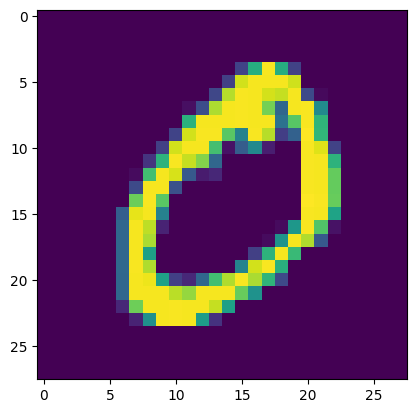

In [7]:
pl.imshow(zero)
# pl.imshow(one)

In [8]:
zero.shape, one.shape

((28, 28), (28, 28))

## Data processing 

### Load model

In [9]:
CHANNEL_N = 10 # Number of CA state channels
BATCH_SIZE = 16
POOL_SIZE = BATCH_SIZE * 10
CELL_FIRE_RATE = 0.5
ADD_NOISE = False

In [10]:
class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does *not* include the greyscale channel.
    # but it does include the 2 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 1]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    gray, state = tf.split(x, [1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))
    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    living_mask = gray > 0.1
    residual_mask = update_mask & living_mask
    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([gray, state], -1)

  @tf.function
  def initialize(self, images):
    state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n])
    images = tf.reshape(images, [-1, 28, 28, 1])
    return tf.concat([images, state], -1)

  @tf.function
  def classify(self, x):
    # The last 2 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-2:]

In [11]:
def get_exp_path(prefix):
  path = prefix
  path += '/0009900'
  return path

def get_model(prefix="../train_log", output='model'):
  path = get_exp_path(prefix)
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel()
    ca.load_weights(path)
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

In [12]:
# ideal outcome
# num_digits = 42

# indexes = np.random.randint(0, x_train.shape[0]-1, size=num_digits)
# figures = color_labels(x_train[indexes], y_train_pic[indexes], dtype=tf.float32)
# tile_digits = generate_tiled_figures(figures, fade_by=0.1)

# imshow(zoom(tile_digits))

In [13]:
ca = get_model()

2023-08-31 14:30:41.409205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Quick test

Let's do a sanity check first.

In [14]:
# set to true if you want to run the sanity check (takes around 50 seconds)
rerun = False
if rerun:
  def eval_perform_steps(ca, x, yt, num_steps):
    yt_label = tf.argmax(yt, axis=-1)

    live_mask = x[..., 0] > 0.1
    live_mask_fl = tf.expand_dims(tf.cast(live_mask, tf.float32), -1)
    dead_channel = tf.cast(x[..., :1] <= 0.1, tf.float32)

    # for now the metric is aggregating everything.
    total_count = tf.reduce_sum(tf.cast(live_mask, tf.float32))

    avg_accuracy_list = []
    avg_total_agreement_list = []
    for _ in range(1, num_steps + 1):
      x = ca(x)

      y = ca.classify(x)
      y_label = tf.argmax(y, axis=-1)

      correct = tf.equal(y_label,  yt_label) & live_mask
      total_correct = tf.reduce_sum(tf.cast(correct, tf.float32))
      avg_accuracy_list.append((total_correct/total_count * 100).numpy().item())

      # agreement metrics
      # Important to exclude dead cells:
      y = y * live_mask_fl
      y_label_plus_mask = tf.argmax(tf.concat([y, dead_channel], -1), axis=-1)
      all_counts = []
      for idx in range(2):
        count_i = tf.reduce_sum(
            tf.cast(tf.equal(y_label_plus_mask, idx), tf.int32), axis=[1,2])
        all_counts.append(count_i)
      all_counts_t = tf.stack(all_counts, 1)
      # Now the trick is that if there is a total agreement, their sum is the same
      # as their max.
      equality = tf.equal(tf.reduce_max(all_counts_t, axis=1),
                          tf.reduce_sum(all_counts_t, axis=1))
      sum_agreement = tf.reduce_sum(tf.cast(equality, tf.float32))
      avg_total_agreement_list.append(sum_agreement.numpy().item() / y.shape[0] * 100)

    return avg_accuracy_list, avg_total_agreement_list

  def eval_batch_fn(ca, x_test, y_test_pic, num_steps, mutate):
    x = ca.initialize(x_test)
    yt = y_test_pic

    avg_acc_l_1, avg_tot_agr_l_1 = eval_perform_steps(ca, x, yt, num_steps)
    if not mutate:
      return avg_acc_l_1, avg_tot_agr_l_1
    # Accuracy after mutation!
    new_idx = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
    new_x, yt = x_test[new_idx], y_test_pic[new_idx]
    new_x = tf.reshape(new_x, [-1, 28, 28, 1])
    mutate_mask = tf.cast(new_x > 0.1, tf.float32)

    x = tf.concat([new_x, x[:,:,:,1:] * mutate_mask], -1)

    avg_acc_l_2, avg_tot_agr_l_2 = eval_perform_steps(ca, x, yt, num_steps)

    return avg_acc_l_1 + avg_acc_l_2, avg_tot_agr_l_1 + avg_tot_agr_l_2

  def eval_all(ca, num_steps, mutate):
    all_accuracies = []
    all_agreements = []

    # total test set is 2115 (check a few cells above)
    num_batches = 10
    eval_bs = 2115 // num_batches
    for i in tqdm.trange(num_batches):
      x_set = x_test[eval_bs*i:eval_bs*(i+1)]
      y_set = y_test_pic[eval_bs*i:eval_bs*(i+1)]
      acc_i, agr_i = eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
      all_accuracies.append(acc_i)
      all_agreements.append(agr_i)

    all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
    all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
    return all_accuracies, all_agreements

  eval_batch = 1000
  num_iters = 10

  all_accuracies, all_agreements = eval_all(ca, num_steps=200, mutate=True)

  pl.figure(figsize=(10, 4))
  pl.title('Average cell accuracy over steps (%)')
  pl.xlabel('Number of steps')
  pl.ylabel('Average cell accuracy (%)')
  pl.xlim(0, 400)
  pl.ylim(0, 100)
  pl.plot(all_accuracies, label="ca")
  pl.legend()
  pl.show()

  pl.figure(figsize=(10, 4))
  pl.title('Average total agreement across batch over steps (%)')
  pl.xlabel('Number of steps')
  pl.ylabel('Average total agreement (%)')
  pl.xlim(0, 400)
  pl.ylim(0, 100)
  pl.plot(all_agreements, label="ca")
  pl.legend()
  pl.show()

Good, it's as we expected! (Compare the two graphs with the ones in the classifying_NCAs_mnist notebook)

### Initialization and processing

Reshaping and preparing our images is quite easy, now.

In [15]:
initd = ca.initialize([zero, one])

initd.shape

2023-08-31 14:30:41.528217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


TensorShape([2, 28, 28, 11])

In [16]:
activated = ca(initd)

activated.shape

2023-08-31 14:30:41.568333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


TensorShape([2, 28, 28, 11])

In [17]:
ys = ca.classify(activated)

ys.shape

2023-08-31 14:30:41.631860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


TensorShape([2, 28, 28, 2])

### Visualization

Let's check that everything makes sense and build some visual intuition while we're at it!

In [18]:
def visualize_channels(image):
  # Get the number of channels in the image
  num_channels = image.shape[-1]

  # Create a figure with a vertical arrangement of subplots
  fig, axes = plt.subplots(ncols=num_channels, figsize=(10, 4))

  # Plot each channel as a grayscale image
  for i in range(num_channels):
    channel_image = image[:, :, i]
    axes[i].imshow(channel_image)
    axes[i].set_title(f'{i + 1}')
    axes[i].axis('off')

  plt.show()

def classify_and_color(ca, x, disable_black=False):
  return color_labels(
      x[:,:,:,0], ca.classify(x), disable_black, dtype=tf.float32)

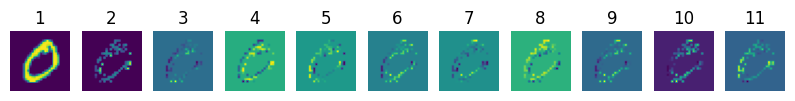

In [19]:
visualize_channels(activated[0])

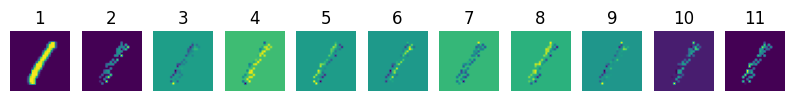

In [20]:
visualize_channels(activated[1])

Looks good, and quite interesting!

Let's take a closer look at the labels.

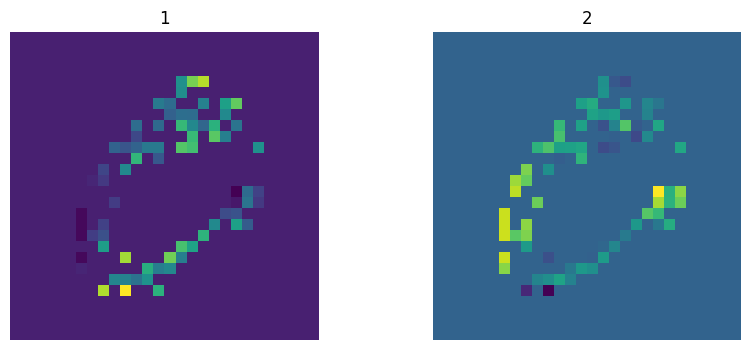

In [21]:
visualize_channels(ys[0])

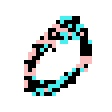

In [22]:
imshow(zoom(classify_and_color(ca, activated)[0]))

Note the correspondence between the channels and the colors: the pixels with the highest intensity in the first channel are colored turqouise, while the ones with the highest intensity in the second channel are colored pink! (Naturally, the ones with low intensities in both are colored black, i.e. the default color).

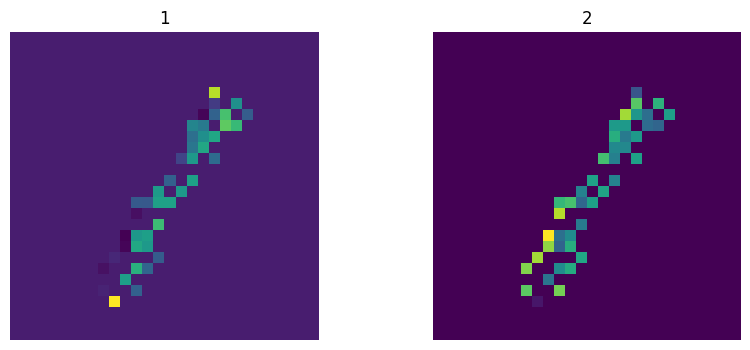

In [23]:
visualize_channels(ys[1])

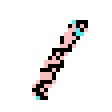

In [24]:
imshow(zoom(classify_and_color(ca, activated)[1])) # see?

## Signaling 

A possible pseudocode:

```
function make_communicating
    take as input the n NCAs
    add 2 additional channels # one for positions, one for labels
    use those channels to implement signaling and message passing # (how?)
    iterate until convergence # (what does that mean?)
```

Once that's done, we simply take the collective label from the extra channels, and we're done!

In [25]:
def assign_numerical_label(activ_x, y):
    # assigns a numerical label (0 or 1, in our case), given the labels in the format output by the model for a single datapoint (i.e. as a 28x28x2 tensor)
    live_cells = activ_x[:, :, 0] > 0.1
    votes_zero = tf.reduce_sum(y[:, :, 0][live_cells]) # only consider alive cells
    votes_one = tf.reduce_sum(y[:, :, 1][live_cells])
    return 0 if votes_zero > votes_one else 1

In [26]:
assign_numerical_label(activated[0], ys[0]), assign_numerical_label(activated[1], ys[1]) # not bad: I expected the 0 to be misclassified

(0, 1)

In [39]:
def add_assign_channels(activated):
    #! note: the order in which the images are presented is assumed to hold (i.e. make sure that the digits follow the desired order in the activated tensor)
    preppd = []
    for x in activated:
        live_cells = x[:, :, 0] > 0.1
        # the value channel is going to contain the bitmap with the correct label
        value_channel = tf.cast(live_cells, tf.float32)

        # the position channel is going to be initialized to zero
        # if no digits is detected to the left, it will remain zero
        # if a digit is detected to the left, it will get the bitmap corresponding to the label of that digit
        # => communication is maintained locally, only between neighbours!
        position_channel = tf.zeros([28, 28]) # initalize positions to zero

        value_channel = tf.reshape(value_channel, [28, 28, 1])
        position_channel = tf.reshape(position_channel, [28, 28, 1])
        new_tensor = tf.concat([x, value_channel, position_channel], axis=-1)
        preppd.append(new_tensor)

    return tf.stack(preppd, axis=0)

In [44]:
prepped = add_assign_channels(activated)

In [45]:
prepped.shape

TensorShape([2, 28, 28, 13])

In [35]:
# for each living cell, let its signal propagate around
def propagate_signal(nca):
    pass

# no matter they way I slice it, simply running inference on each cells separately and concatenating the labels sounds like the best way to classify arbitrary numbers...

In [47]:
# in this notebook, we work with n = 2
united = tf.concat([prepped[0], prepped[1]], axis=1)

united.shape

TensorShape([28, 56, 13])

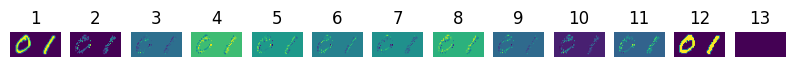

In [48]:
visualize_channels(united)